<a href="https://colab.research.google.com/github/kei-mo/study-diffusion-model/blob/main/sde_ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated by ChatGPT o3-mini-high and modified by kei-mo

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 0. デバイスの設定 (GPUがあればGPUを使用)
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===========================
# 1. ハイパーパラメータの設定
# ===========================
T = 1.0              # 最大時刻
beta = 10.0          # 定数beta（大きくすることでT=1でほぼ完全なノイズ状態に）
num_epochs = 10000   # 学習エポック数（デモ用なので少なめに設定）
batch_size = 128
learning_rate = 1e-3

# α(t)=exp(-beta*t)
def alpha_bar(t):
    return torch.exp(-beta * t)

# =========================================
# 2. 混合ガウス分布からサンプリングする関数
# =========================================
def sample_data(batch_size):
    # 2成分の混合ガウス：平均[-2,0] と [2,0]、共分散は単位行列
    means = [torch.tensor([-2.0, 0.0], device=device), torch.tensor([2.0, 0.0], device=device)]
    comp = torch.randint(0, 2, (batch_size,), device=device)
    samples = []
    for i in range(batch_size):
        mu = means[comp[i]]
        samples.append(mu + torch.randn(2, device=device))
    return torch.stack(samples, dim=0)

# ====================================
# 3. スコア推定のためのネットワークの定義
# ====================================
class ScoreNet(nn.Module):
    def __init__(self):
        super(ScoreNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),  # 入力：2次元のxとスカラーt
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)   # 出力：2次元のスコア
        )
    def forward(self, x, t):
        # tが1次元の場合、unsqueezeして結合
        if t.dim() == 1:
            t = t.unsqueeze(1)
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

# モデルのインスタンス生成とデバイスへの移動
score_model = ScoreNet().to(device)
optimizer = optim.Adam(score_model.parameters(), lr=learning_rate)

# ===========================
# 4. スコアマッチングによる学習ループ
# ===========================
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # (1) 混合ガウス分布からデータ x0 をサンプリング
    x0 = sample_data(batch_size)  # shape: [batch_size, 2]

    # (2) t を一様に [0, T] からサンプリング（各サンプル毎に異なるt）
    t = torch.rand(batch_size, device=device) * T  # shape: [batch_size]

    # (3) α(t) の計算
    a = alpha_bar(t).unsqueeze(1)  # shape: [batch_size, 1]

    # (4) ノイズ ε のサンプリング
    noise = torch.randn_like(x0)

    # (5) forward process により x_t を生成
    sqrt_a = torch.sqrt(a)
    sqrt_one_minus_a = torch.sqrt(1 - a)
    x_t = sqrt_a * x0 + sqrt_one_minus_a * noise

    # (6) ターゲットスコア： s_target = -ε / sqrt(1 - α(t))
    target_score = - noise / sqrt_one_minus_a

    # (7) ネットワークによるスコア推定
    s_pred = score_model(x_t, t)

    # (8) MSE損失の計算
    loss = ((s_pred - target_score) ** 2).mean()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.6f}")

# -----------------------------
# 追加の可視化①：元データ分布のプロット
# -----------------------------
x_data = sample_data(1000).detach().cpu().numpy()
plt.figure(figsize=(6,6))
plt.scatter(x_data[:,0], x_data[:,1], s=10, alpha=0.5, color='red')
plt.title("混合ガウス分布からの元データ")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# -----------------------------
# 追加の可視化②：スコア関数の可視化
# -----------------------------
# 固定時刻 t_plot での入力空間上のスコア（勾配）を可視化
t_plot = 0.5
n_grid = 20
x_lin = np.linspace(-6, 6, n_grid)
y_lin = np.linspace(-6, 6, n_grid)
xx, yy = np.meshgrid(x_lin, y_lin)
grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=device)
t_tensor = torch.full((grid_tensor.size(0),), t_plot, device=device)
with torch.no_grad():
    score_vals = score_model(grid_tensor, t_tensor).cpu().numpy()
# 整形してベクトル場をプロット
u = score_vals[:, 0].reshape(n_grid, n_grid)
v = score_vals[:, 1].reshape(n_grid, n_grid)
plt.figure(figsize=(7,7))
plt.quiver(xx, yy, u, v, color='blue', angles='xy')
plt.title(f"時刻 t={t_plot} におけるスコア関数のベクトル場")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.grid(True)
plt.show()


Using device: cpu
Epoch 0: loss = 1.117051


KeyboardInterrupt: 

In [ ]:

# -----------------------------
# 追加の可視化③：Euler-Maruyama法による逆SDEサンプリングの軌跡
# -----------------------------
def sample_reverse_sde(x_T, num_steps, record_trajectory=False, record_interval=100):
    """
    逆SDEのEuler-Maruyama法によるサンプリング
    逆SDE: dx = [ -0.5*beta*x - beta*s_theta(x,t) ] dt + sqrt(beta) dW̄
    record_trajectory が True の場合、指定間隔で状態を記録する。
    """
    dt = T / num_steps
    x = x_T
    t = T * torch.ones(x_T.size(0), device=device)
    trajectories = []
    times = []
    if record_trajectory:
        trajectories.append(x.clone())
        times.append(t.clone())
    for i in range(num_steps):
        drift = -0.5 * beta * x - beta * score_model(x, t)
        noise = torch.randn_like(x)
        x = x + drift * dt + torch.sqrt(torch.tensor(beta * dt, device=device)) * noise
        t = t - dt
        if record_trajectory and ((i+1) % record_interval == 0 or i == num_steps - 1):
            trajectories.append(x.clone())
            times.append(t.clone())
    if record_trajectory:
        return x, trajectories, times
    else:
        return x

# サンプル生成と軌跡の記録
num_samples = 500  # 軌跡表示用に少なめのサンプル数にする
x_T = torch.randn(num_samples, 2, device=device)
x_final, traj, traj_times = sample_reverse_sde(x_T, num_steps=1000, record_trajectory=True, record_interval=100)

# 軌跡表示のため、選んだ数個（例：10個）のサンプルの軌跡をプロット
traj_np = [t.cpu().numpy() for t in traj]  # 各記録時刻での状態（リスト：各要素 shape: [num_samples,2]）
# 選択するサンプルのインデックス（例：10サンプル）
sel_idx = np.random.choice(num_samples, size=10, replace=False)

plt.figure(figsize=(8,8))
# 各記録時刻における全体のサンプル散布図（薄いグレー）を背景に
for state in traj_np:
    plt.scatter(state[:,0], state[:,1], s=5, color='lightgray', alpha=0.5)
# 選択したサンプルの軌跡をラインプロット
for idx in sel_idx:
    path = np.array([state[idx] for state in traj_np])
    plt.plot(path[:,0], path[:,1], marker='o', label=f"サンプル {idx}")
plt.title("逆SDEサンプリング中の軌跡（Euler-Maruyama法）")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 追加の可視化④：最終サンプルの散布図
# -----------------------------
x_gen = x_final.detach().cpu().numpy()
plt.figure(figsize=(6,6))
plt.scatter(x_gen[:,0], x_gen[:,1], s=10, alpha=0.5, color='green')
plt.title("学習済みスコアによる逆SDE最終サンプル")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ===========================
# 1. ハイパーパラメータの設定
# ===========================
T = 1.0  # 最大時刻
beta = 10.0  # 定数beta（大きくすることでT=1でほぼ完全なノイズ状態に）
num_epochs = 10000  # 学習エポック数（デモ用なので少なめに設定してもOK）
batch_size = 128
learning_rate = 1e-3


# α(t)=exp(-beta*t)
def alpha_bar(t):
    return torch.exp(-beta * t)


# =========================================
# 2. 混合ガウス分布からサンプリングする関数
# =========================================
def sample_data(batch_size):
    # 2成分の混合ガウス：平均[-2,0] と [2,0]、共分散は単位行列
    means = [torch.tensor([-2.0, 0.0]), torch.tensor([2.0, 0.0])]
    # 各サンプルで成分をランダムに選択
    comp = torch.randint(0, 2, (batch_size,))
    samples = []
    for i in range(batch_size):
        mu = means[comp[i]]
        samples.append(mu + torch.randn(2))
    return torch.stack(samples, dim=0)


# ====================================
# 3. スコア推定のためのネットワークの定義
# ====================================
class ScoreNet(nn.Module):
    def __init__(self):
        super(ScoreNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),  # 入力：2次元のxとスカラーt
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # 出力：2次元のスコア
        )

    def forward(self, x, t):
        # tが1次元の場合、unsqueezeして結合できるようにする
        if t.dim() == 1:
            t = t.unsqueeze(1)
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)


# インスタンス生成
score_model = ScoreNet()
optimizer = optim.Adam(score_model.parameters(), lr=learning_rate)

# ===========================
# 4. スコアマッチングによる学習ループ
# ===========================
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # (1) データ x0 を混合ガウス分布からサンプリング
    x0 = sample_data(batch_size)  # shape: [batch_size, 2]

    # (2) t を一様に [0, T] からサンプル（各サンプル毎に異なるt）
    t = torch.rand(batch_size) * T  # shape: [batch_size]

    # (3) α(t) を計算（shapeを合わせるためunsqueeze）
    a = alpha_bar(t).unsqueeze(1)  # shape: [batch_size, 1]

    # (4) ノイズ ε を標準正規分布からサンプリング
    noise = torch.randn_like(x0)

    # (5) forward process により x_t を生成
    sqrt_a = torch.sqrt(a)
    sqrt_one_minus_a = torch.sqrt(1 - a)
    x_t = sqrt_a * x0 + sqrt_one_minus_a * noise

    # (6) ターゲットスコア： s_target = -ε / sqrt(1 - α(t))
    target_score = -noise / sqrt_one_minus_a

    # (7) ネットワークによるスコア推定
    s_pred = score_model(x_t, t)

    # (8) MSE損失の計算
    loss = ((s_pred - target_score) ** 2).mean()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.6f}")


Epoch 0: loss = 3.214437
Epoch 1000: loss = 0.271448
Epoch 2000: loss = 0.235755
Epoch 3000: loss = 0.405704
Epoch 4000: loss = 0.356037
Epoch 5000: loss = 0.953506
Epoch 6000: loss = 1.450789
Epoch 7000: loss = 0.706370
Epoch 8000: loss = 0.311441
Epoch 9000: loss = 1.317262


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28168 (\N{CJK UNIFIED IDEOGRAPH-6E08}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

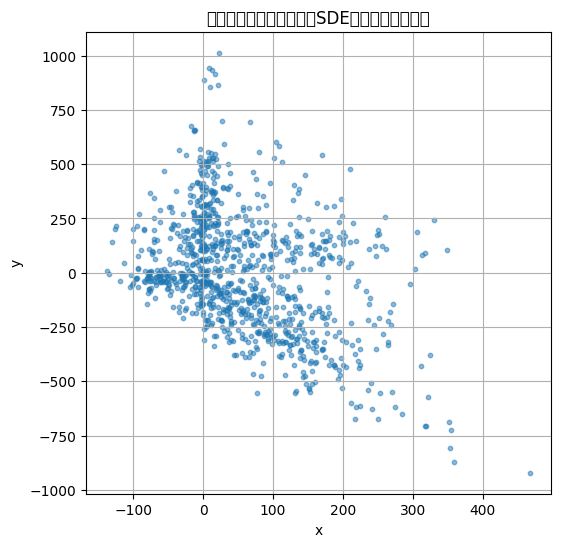

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12460 (\N{KATAKANA LETTER GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byt

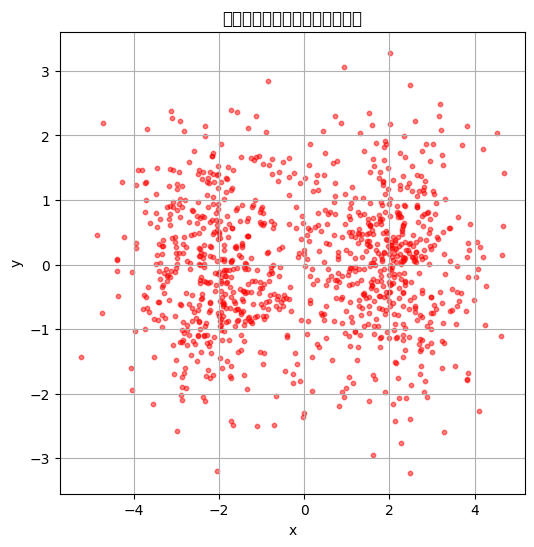

In [2]:
# ===========================================
# 5. 学習済みスコアを用いた逆SDEによるサンプリング
# ===========================================
def sample_reverse_sde(x_T, num_steps):
    """
    逆SDEのEuler-Maruyama法によるサンプリング
    逆SDE: dx = [ -0.5*beta*x - beta*s_theta(x,t) ] dt + sqrt(beta) dW̄
    """
    dt = T / num_steps
    x = x_T
    # 初期tはT（各サンプル毎に）
    t = T * torch.ones(x_T.size(0))
    for i in range(num_steps):
        # 逆SDEのドリフト項
        drift = -0.5 * beta * x - beta * score_model(x, t)
        # ノイズ項
        noise = torch.randn_like(x)
        x = x + drift * dt + torch.sqrt(torch.tensor(beta * dt)) * noise
        t = t - dt  # 時刻を逆行
    return x


# サンプル生成（num_samples個）
num_samples = 1000
# 逆SDEの開始点 x_T は、forward process により完全なノイズ状態となるので、標準正規分布からサンプル
x_T = torch.randn(num_samples, 2)
x_gen = sample_reverse_sde(x_T, num_steps=1000)

# ---------------------
# 6. 結果の可視化
# ---------------------
import numpy as np

# 生成されたサンプルのプロット
x_gen_np = x_gen.detach().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(x_gen_np[:, 0], x_gen_np[:, 1], s=10, alpha=0.5)
plt.title("学習済みスコアによる逆SDEサンプリング結果")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# 元のデータ分布も確認
x_data = sample_data(1000).detach().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(x_data[:, 0], x_data[:, 1], s=10, alpha=0.5, color="red")
plt.title("混合ガウス分布からの元データ")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()
